**Корректность проверена на Python 3.7:**
+ pandas 0.23.0
+ numpy 1.14.5
+ scipy 1.1.0
+ statsmodels 0.9.0

# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


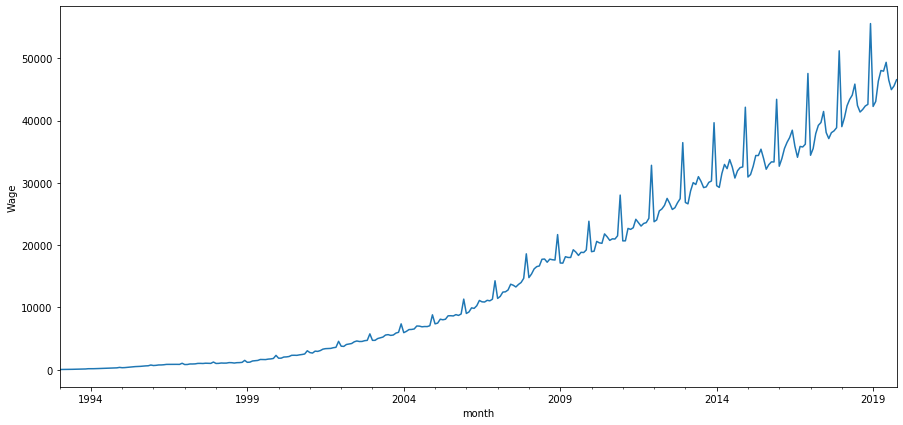

In [39]:
WAG = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
WAG.columns = ['wage']
plt.figure(figsize(15,7))
WAG.wage.plot()
plt.ylabel('Wage')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.051161


<Figure size 1080x720 with 0 Axes>

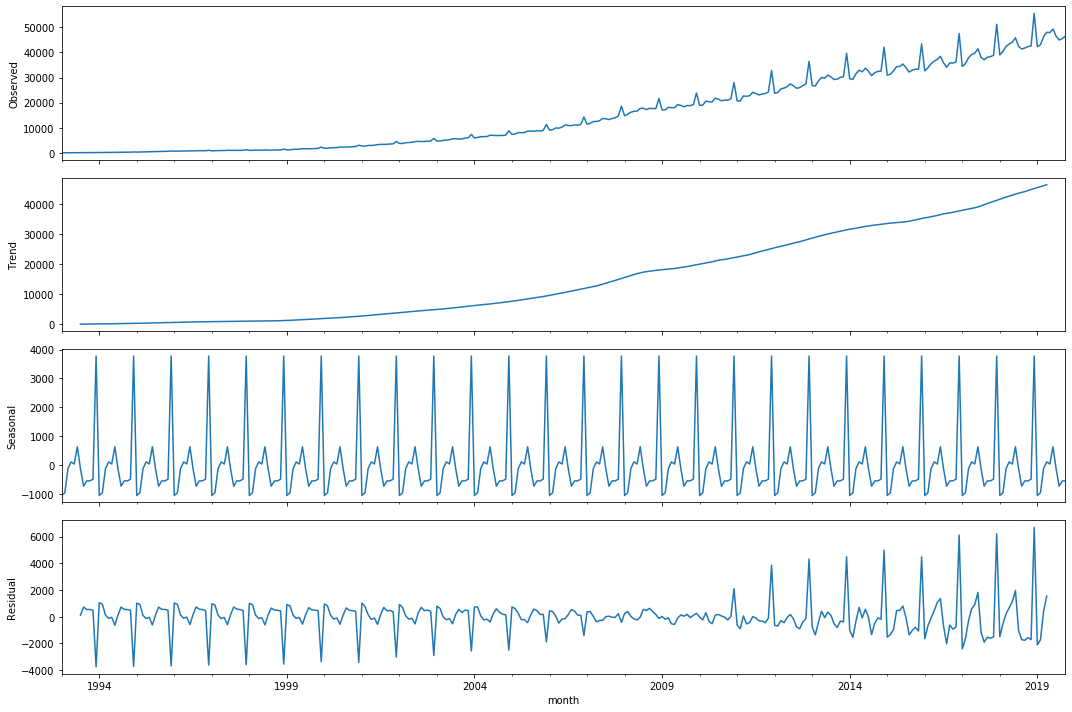

In [40]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales)[1])
plt.show()

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.288315
Критерий Дики-Фуллера: p=0.029565


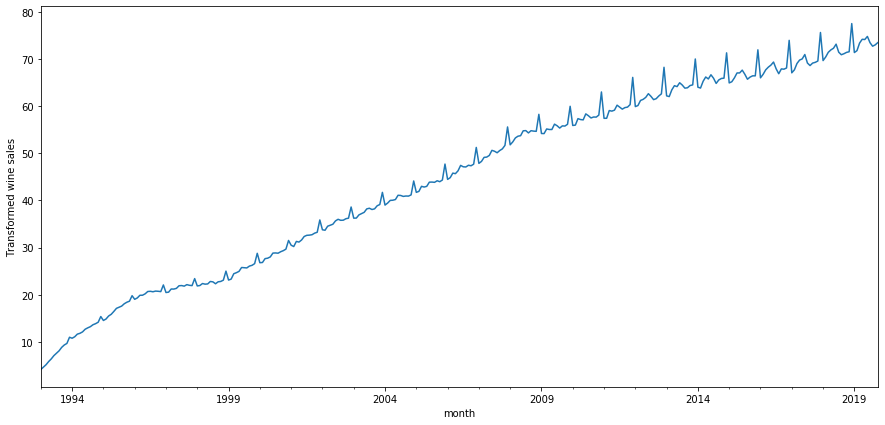

In [41]:
WAG['wage_box'], lmbda = stats.boxcox(WAG.wage)
plt.figure(figsize(15,7))
WAG.wage_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wine.sales_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.123755


<Figure size 1080x720 with 0 Axes>

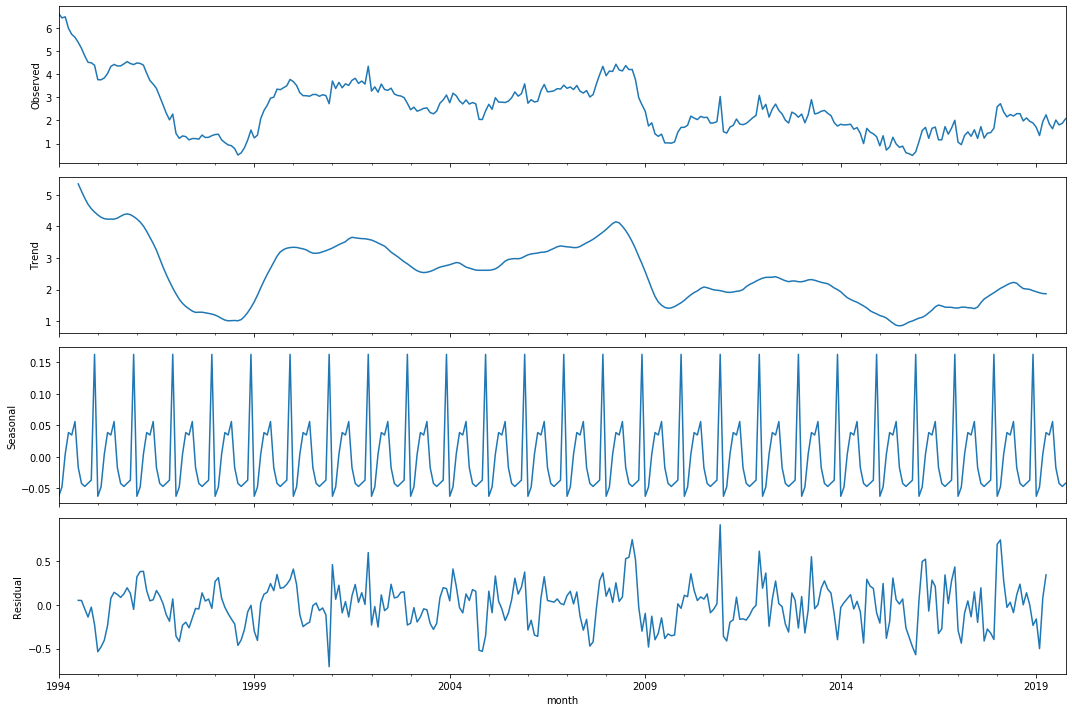

In [42]:
WAG['wage_box_diff'] = WAG.wage_box - WAG.wage_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

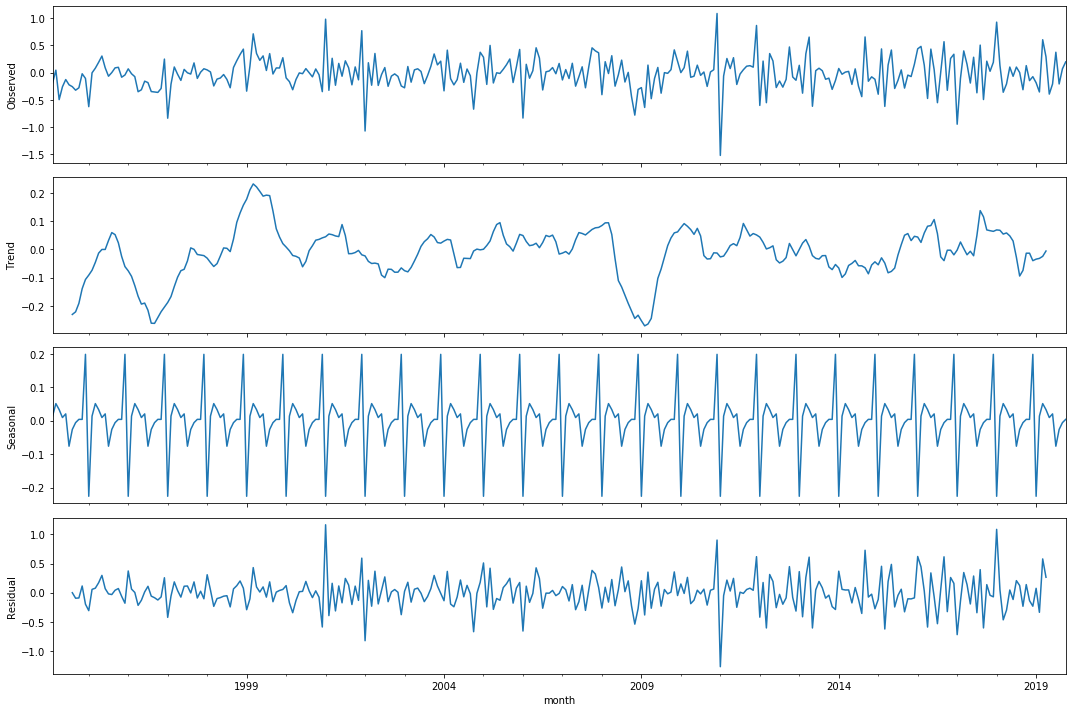

In [43]:
WAG['wage_box_diff2'] = WAG.wage_box_diff - WAG.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

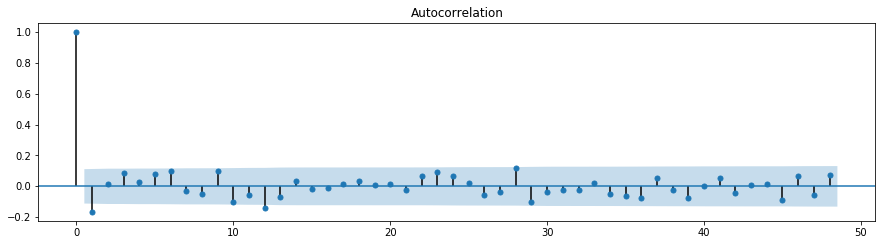

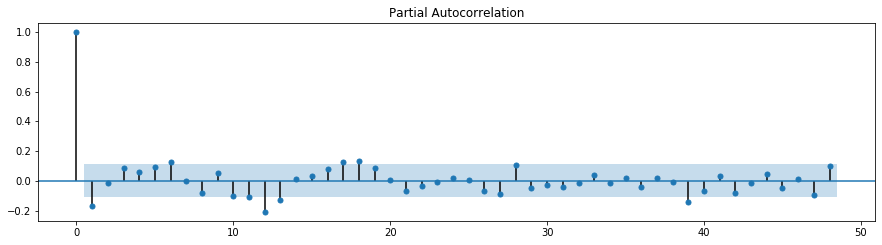

In [44]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.wage_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [49]:
ps = range(0, 12)
d=1
qs = range(0, 11)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [50]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

132

In [51]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 5min 6s


Если в предыдущей ячейке возникает ошибка, убедитесь, что обновили statsmodels до версии не меньше 0.8.0rc1.

In [52]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

        parameters         aic
112  (10, 2, 0, 0)  130.061109
25    (2, 3, 0, 0)  131.252813
36    (3, 3, 0, 0)  131.490174
26    (2, 4, 0, 0)  131.559805
84    (7, 7, 0, 0)  131.808419


Лучшая модель:

In [53]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                            wage_box   No. Observations:                  322
Model:             SARIMAX(10, 1, 2)x(0, 1, 0, 12)   Log Likelihood                 -52.031
Date:                             Mon, 27 Jan 2020   AIC                            130.061
Time:                                     14:35:41   BIC                            178.595
Sample:                                 01-01-1993   HQIC                           149.465
                                      - 10-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1639      0.097     11.990      0.000       0.974       1.354
ar.L2         -0.4524      

Её остатки:

Критерий Стьюдента: p=0.282741
Критерий Дики-Фуллера: p=0.000000


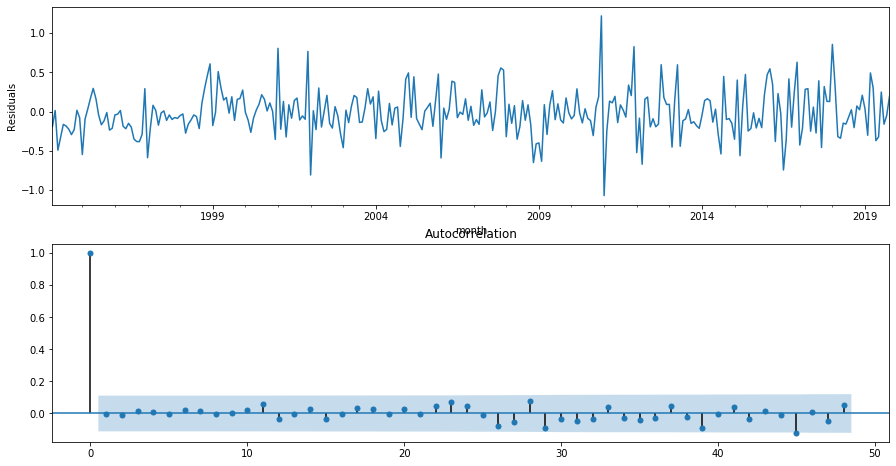

In [54]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

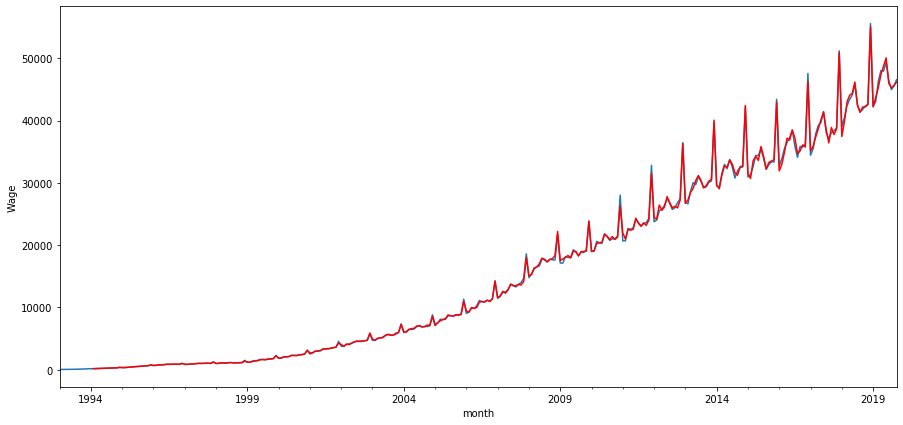

In [55]:
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
WAG.wage.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

### Прогноз

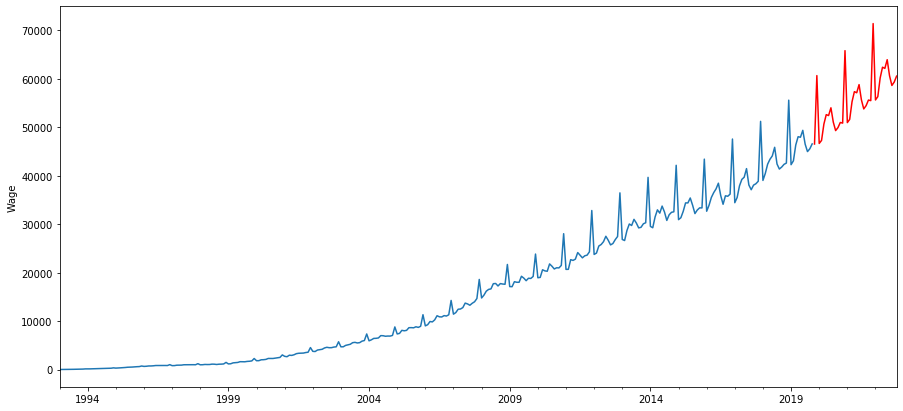

In [70]:
WAG2 = WAG[['wage']]
date_list = [datetime.datetime.strptime("2019-11-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(best_model.predict(start=322, end=358), lmbda)

plt.figure(figsize(15,7))
WAG2.wage.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()

In [71]:
WAG2.tail(48)

,wage,forecast
2018-11-01,42595.0,NaN
2018-12-01,55569.0,NaN
2019-01-01,42263.0,NaN
2019-02-01,43062.0,NaN
2019-03-01,46324.0,NaN
2019-04-01,48030.0,NaN
2019-05-01,47926.0,NaN
2019-06-01,49348.0,NaN
2019-07-01,46509.0,NaN
2019-08-01,44961.0,NaN
